<a href="https://colab.research.google.com/github/hpatel1398/het-patel/blob/master/NLPProjectph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emoji

In [ ]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import nltk 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [ ]:
def startsWithDateAndTime(s):
    pattern = '^\d{1,2}/\d{1,2}/\d{1,2}, \d{1,2}:\d{1,2}\S [AaPp][Mm] -'
    result = re.match(pattern, s)
    if result:
        return True
    return False
  
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # Name
        '([\w]+[\s]+[\w]+):',              # Name + Surname
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    
        '([\w]+)[\u263a-\U0001f999]+:',    #Name with emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return dateTime, author, message

In [ ]:
parsedData = [] 

conversationPath = '/content/WhatsAppChat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() 
    messageBuffer = [] 
    datetime, author = None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([dateTime, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            dateTime, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)
   
chat = pd.DataFrame(parsedData, columns=['DateTime', 'Author', 'Message']) 

In [ ]:
chat.head()

,DateTime,Author,Message
0,"11/11/20, 11:16 AM",None,"Person_1 created group ""Project Team🖥️💵 📊📈"""
1,"4/2/21, 10:17 AM",None,Person_1 added you
2,"4/2/21, 10:17 AM",None,You're now an admin
3,"4/2/21, 10:18 AM",Person_1,Software nu title apva vinnati
4,"4/2/21, 10:18 AM",Person_4,😂


In [ ]:
nltk.download('nps_chat')
nltk.download('punkt')

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
software_group = list(chat.Author.unique())
software_group
aliases = ['Ram', 'Sita', 'Laxman', 'Bharat','Hanuman']
chat['Author'].replace(software_group, aliases, inplace=True)
chat.head()

,DateTime,Author,Message
0,"11/11/20, 11:16 AM",Ram,"Person_1 created group ""Project Team🖥️💵 📊📈"""
1,"4/2/21, 10:17 AM",Ram,Person_1 added you
2,"4/2/21, 10:17 AM",Ram,You're now an admin
3,"4/2/21, 10:18 AM",Sita,Software nu title apva vinnati
4,"4/2/21, 10:18 AM",Laxman,😂


In [ ]:
chat["DateTime"] = pd.to_datetime(chat["DateTime"])
chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  1776 non-null   datetime64[ns]
 1   Author    1776 non-null   object        
 2   Message   1776 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 41.8+ KB


In [ ]:
chat['weekday'] = chat['DateTime'].apply(lambda x: x.day_name())
# new column month_sent
chat['month_sent'] = chat['DateTime'].apply(lambda x: x.month_name()) 
#column date
chat['date'] = [d.date() for d in chat['DateTime']] 
#column hour
chat['hour'] = [d.time().hour for d in chat['DateTime']]

In [ ]:
#column urlcount
URLPATTERN = r'(https?://\S+)'
chat['urlcount'] = chat.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
#column Letter_Count
chat['Letter_Count'] = chat['Message'].apply(lambda s : len(s))
#column Word_Count
chat['Word_Count'] = chat['Message'].apply(lambda s : len(s.split(' ')))

In [ ]:
def split_count(text):
  emoji_list = []
  data = regex.findall(r'\X', text)
  for word in data:
          if any(char in emoji.UNICODE_EMOJI for char in word):
              emoji_list.append(word)
  return emoji_list
chat["emoji"] = chat["Message"].apply(split_count)

In [ ]:
chat.head()

,DateTime,Author,Message,weekday,month_sent,date,hour,urlcount,Letter_Count,Word_Count,emoji
0,2020-11-11 11:16:00,Ram,"Person_1 created group ""Project Team🖥️💵 📊📈""",Wednesday,November,2020-11-11,11,0,43,6,[]
1,2021-04-02 10:17:00,Ram,Person_1 added you,Friday,April,2021-04-02,10,0,18,3,[]
2,2021-04-02 10:17:00,Ram,You're now an admin,Friday,April,2021-04-02,10,0,19,4,[]
3,2021-04-02 10:18:00,Sita,Software nu title apva vinnati,Friday,April,2021-04-02,10,0,30,5,[]
4,2021-04-02 10:18:00,Laxman,😂,Friday,April,2021-04-02,10,0,1,1,[]


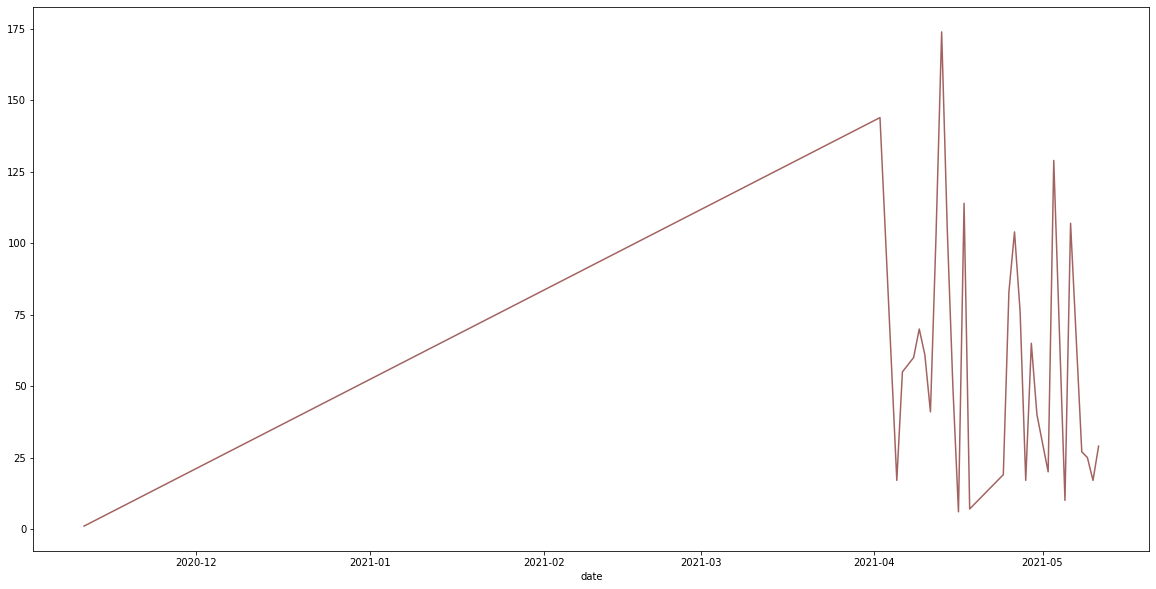

In [ ]:
date_grouped = chat.groupby('date')['Message'].count().plot(kind='line', figsize=(20,10), color='#A26360')

In [ ]:
weekday_grouped_msg =  (chat.set_index('weekday')['Message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
weekday_grouped_msg

fig = px.line_polar(weekday_grouped_msg, r='count', theta='weekday', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

In [ ]:
hour_grouped_msg =  (chat.set_index('hour')['Message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
fig = px.bar(hour_grouped_msg, x='hour', y='count',
                 labels={'hour':'24 Hour Period'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Total Messages by Hour of the Day')
fig.show()

In [ ]:
total_messages = chat.shape[0]
media_messages = chat[chat['Message'] == '<Multimedia omitido>'].shape[0]
average_message_words = chat['Word_Count'].mean()
average_message_letters = chat['Letter_Count'].mean()
average_message_day = chat.groupby('date')['Message'].count().mean()
print('Total Messages ',total_messages)
print('Media Message', media_messages)
print('Average Words by Messages', round(average_message_words, 2))
print('Average Letters by Messages', round(average_message_letters, 2))
print('Average Message Per Day', round(average_message_day, 2))


Total Messages  1776
Media Message 0
Average Words by Messages 5.57
Average Letters by Messages 28.15
Average Message Per Day 59.2


Hanuman    631
Sita       590
Bharat     451
Laxman      99
Ram          5
Name: Author, dtype: int64

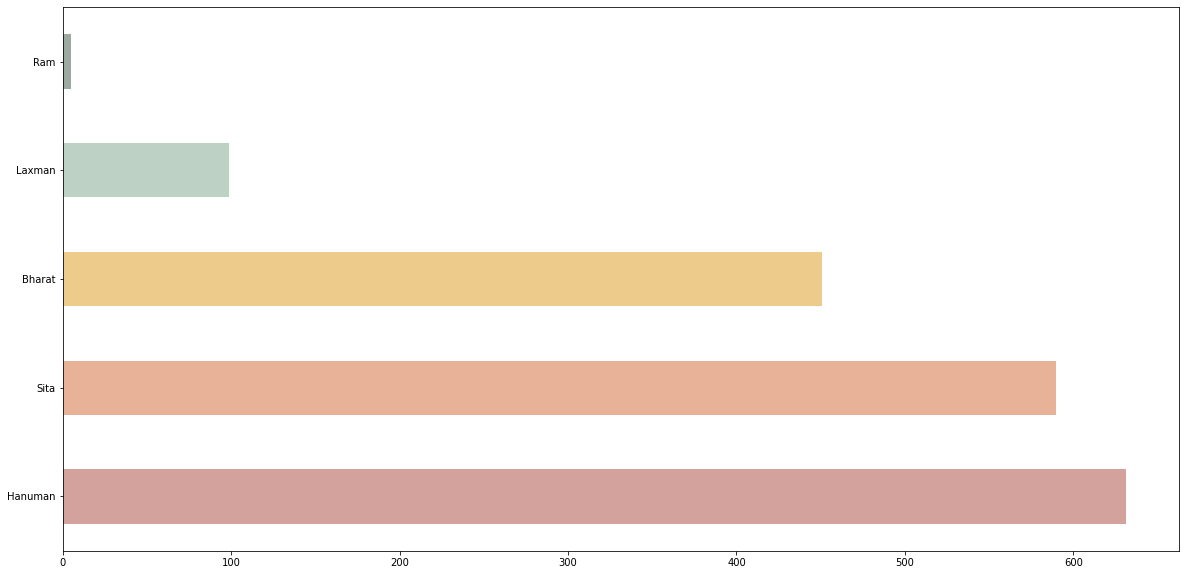

In [ ]:
qty_message_author = chat['Author'].value_counts()
qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
qty_message_author

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
commond_words = chat[['Author','Message']].copy()

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

stopwords = list(STOPWORDS)
extra = ["<multimedia", "omitido>", "k", "d","si","multimedia", "omitido"]
stopwords = stopwords + extra
commond_words["Message"] = (commond_words["Message"]
                           .str.lower()
                           .str.split()
                           .apply(lambda x: [item for item in x if item not in stopwords])
                           .explode()
                           .reset_index(drop=True)
                 )

commond_words['Message']= commond_words['Message'].replace('nan', np.NaN)
commond_words['Message']= commond_words['Message'].replace('', np.NaN)
commond_words['Message']= commond_words.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja")
commond_words['Message']= commond_words.Message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja")


words_dict = dict(Counter(commond_words.Message))
words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)

words_dict = pd.DataFrame(words_dict, columns=['words', 'count'])

fig = px.bar(words_dict.head(10).dropna(), x='words', y='count',
                 labels={'words':'Common Words'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Commond Words Chart')
fig.show()

In [ ]:
TopTen =5
author_commond_words =  (commond_words.set_index('Author')['Message']
                          .dropna()
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .head(TopTen)
                          .rename_axis(('Author','words'))
                          .reset_index(name='count'))

l = author_commond_words.Author.unique()
for i in range(len(l)):
    dummy_df = author_commond_words[author_commond_words['Author'] == l[i]]
    print(dummy_df)
    print('Most Commond Words by', l[i])
    fig = px.bar(dummy_df, x='words', y='count',
                 labels={'words':'Author Common Words'}, 
                 height=380)
    fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
    fig.update_layout(title_text='Author Commond Words Chart')
    fig.show()

   Author words  count
0  Bharat    ha     12
1  Bharat   hai     12
2  Bharat   hey      8
3  Bharat    ne      6
4  Bharat   toh      6
Most Commond Words by Bharat


    Author   words  count
5  Hanuman     hai     17
6  Hanuman     toh     10
7  Hanuman     kya      8
8  Hanuman    nahi      8
9  Hanuman  <media      7
Most Commond Words by Hanuman


    Author words  count
10  Laxman   toh      4
11  Laxman   bhi      3
12  Laxman   tha      3
13  Laxman   bas      2
14  Laxman   hai      2
Most Commond Words by Laxman


   Author     words  count
15    Ram  person_1      2
16    Ram   changed      1
17    Ram   created      1
18    Ram     group      1
Most Commond Words by Ram


   Author     words  count
19   Sita       hai     13
20   Sita        na     12
21   Sita  omitted>     11
22   Sita       toh     11
23   Sita       kya      8
Most Commond Words by Sita


In [ ]:
#function to display wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

#function to remove urls from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

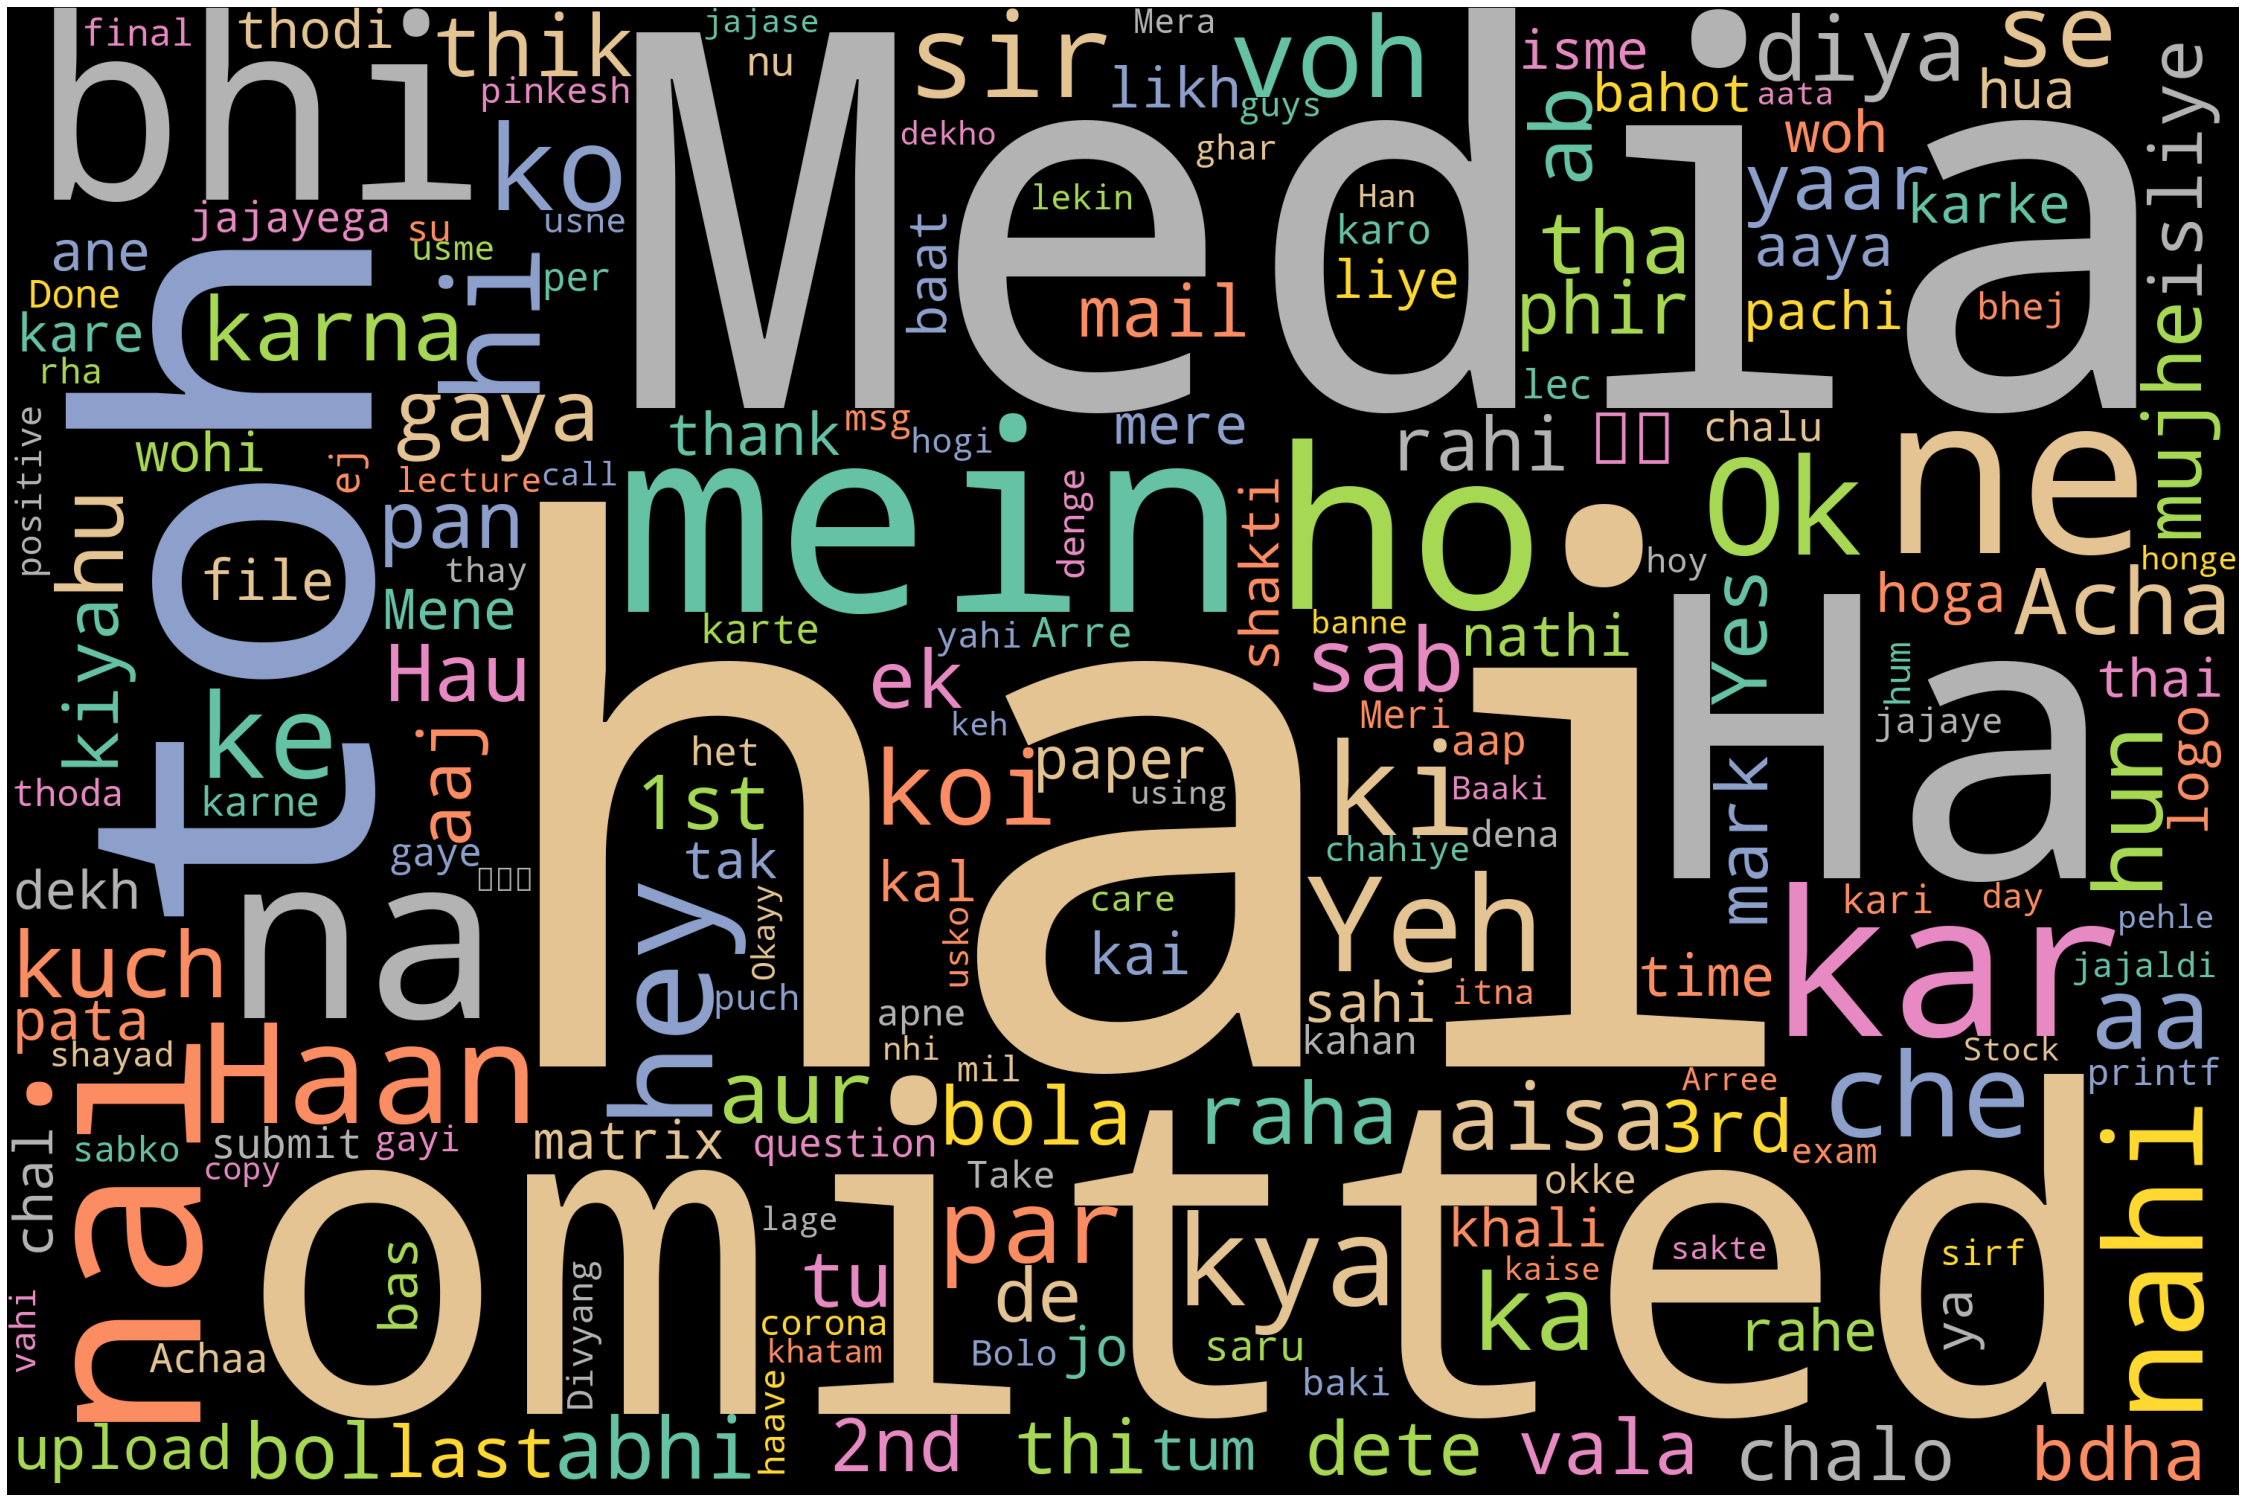

In [ ]:
chat_word_cloud = chat[['Message']].copy()
#chat_word_cloud['Message']= chat_word_cloud['Message'].apply(remove_emoji)
chat_word_cloud['Message']= chat_word_cloud['Message'].apply(remove_urls)
chat_word_cloud['Message']= chat_word_cloud['Message'].replace('nan', np.NaN)
chat_word_cloud['Message']= chat_word_cloud['Message'].replace('', np.NaN)
chat_word_cloud['Message']= chat_word_cloud.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja")
chat_word_cloud['Message']= chat_word_cloud.Message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja")
text = " ".join(review for review in chat_word_cloud.Message.dropna())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
background_color='black', colormap='Set2', collocations=False,
stopwords = stopwords).generate(text)
# Plot
plot_cloud(wordcloud)